In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,  GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
#from sklearn.metrics import accuracy_score, plot_confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import time
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
random_state = 0

In [8]:
df=pd.read_csv('/dataset_110.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
1,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
2,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
3,53,technician,married,secondary,no,6,yes,no,unknown,5,may,517,1,-1,0,unknown,no
4,58,technician,married,unknown,no,71,yes,no,unknown,5,may,71,1,-1,0,unknown,no


### Feature Engineering, Scaling:

In [9]:
#X&y
X = df.drop(columns=["y"])
y = df["y"]

#Use StandarScaler to standardize all numerical features, so their mean and standard deviation are zero and one, respectively.
scaler = StandardScaler()
X[X.select_dtypes("number").columns] = scaler.fit_transform(X.select_dtypes("number"))


#Encode each categorical feature by using ordinal encoder.
ordEnc = OrdinalEncoder(dtype=np.int)
X[X.select_dtypes("object").columns] = ordEnc.fit_transform(X.select_dtypes("object"))

#Also, don't forget to encode the label.
labEnc = LabelEncoder()
y = labEnc.fit_transform(y)

### Recursive Feature Engineering, to select and train only on Important Features.
### Do feature selection by using recursive feature elimination (RFE). Use Logistic Regression classifier as the estimator, and set the fold (k) for cross-validation to 10.


In [11]:
#Using, Logistic Regression as the Estimtator.
estimator = LogisticRegression(random_state=random_state)
rfecv = RFECV(estimator=estimator, cv=StratifiedKFold(10, random_state=random_state, shuffle=True), scoring="accuracy")
rfecv.fit(X, y)
#Make a line plot of number of selected features against cross-validation score. Then, print the optimal number of features.
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.grid()
plt.xticks(range(1, X.shape[1]+1))
plt.xlabel("No. Selected Features")
plt.ylabel("Cross Validation Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()

#print("The optimal number of features: {}".format(rfecv.n_features_))

Split the feature-selected DataFrame into train and test set. Also, do the same thing on the original DataFrame.

In [ ]:
X_rfe = X.iloc[:, rfecv.support_]
X_train, X_test, X_rfe_train, X_rfe_test, y_train, y_test = train_test_split(X, X_rfe, y,
                                                                             train_size=0.8,
                                                                             stratify=y,
                                                                        random_state=random_state)
# print("Train size: {}".format(len(y_train)))
# print("Test size: {}".format(len(y_test)))

Model training using feature-selected data: started!
Logistic Regression training: done! Training time: 3.2043986320495605 seconds.
Best parameters: {'C': 1.0, 'penalty': 'l2'}


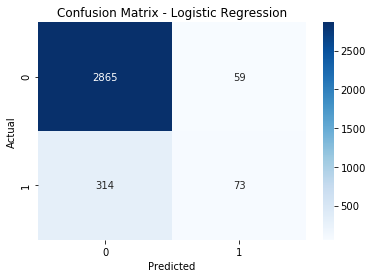

XGBoost training: done! Training time: 24.463140726089478 seconds.
Best parameters: {'learning_rate': 0.1, 'max_depth': 3}


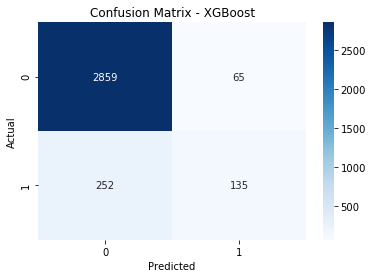

Random Forest training: done! Training time: 138.60211515426636 seconds.
Best parameters: {'max_depth': None, 'n_estimators': 500}


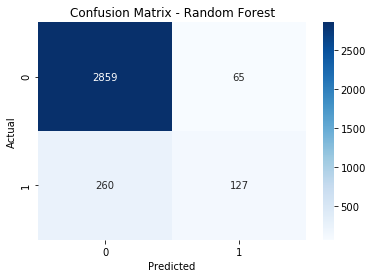

Model training using feature-selected data: done!
Optimal parameters for all classifiers:
             Classifier                           Best Parameters
0  Logistic Regression               {'C': 1.0, 'penalty': 'l2'}
1              XGBoost    {'learning_rate': 0.1, 'max_depth': 3}
2        Random Forest  {'max_depth': None, 'n_estimators': 500}


In [ ]:
import pandas as pd
# Define the classifiers and their corresponding parameter grids
classifiers = {
    "Logistic Regression": (LogisticRegression(random_state=42), {"C": [0.1, 1.0, 10.0, 100.0], "penalty": ["l1", "l2"]}),
    "XGBoost": (XGBClassifier(random_state=42), {"learning_rate": [0.1, 0.01, 0.001], "max_depth": [3, 5, 7]}),
    "Random Forest": (RandomForestClassifier(random_state=42), {"n_estimators": [50, 100, 200, 500], "max_depth": [None, 5, 10, 15]})
}

clfs = {}
clf_keys = classifiers.keys()
# Define an empty dataframe to store the optimal parameters
optimal_params_df = pd.DataFrame(columns=["Classifier", "Best Parameters"])

clfs = {}
clf_keys = classifiers.keys()
# Feature-selected dataset
clfs_rfe = {}
confusion_matrices_rfe = {}
print("Model training using feature-selected data: started!")
for clf_rfe_name in clf_keys:
    clf_rfe, param_grid_rfe = classifiers[clf_rfe_name]

    # Perform grid search for the current classifier
    grid_search_rfe = GridSearchCV(clf_rfe, param_grid_rfe, cv=5)  # Specify the number of folds for cross-validation (e.g., 5-fold)

    start_time = time.time()

    grid_search_rfe.fit(X_rfe_train, y_train)
    clf_rfe = grid_search_rfe.best_estimator_

    end_time = time.time()
    training_time = end_time - start_time

    clfs_rfe[clf_rfe_name] = clf_rfe

    best_params_rfe = grid_search_rfe.best_params_  # Get the best parameters

    print(clf_rfe_name, "training: done! Training time:", training_time, "seconds.")
    print("Best parameters:", best_params_rfe)  # Print the best parameters

    # Compute confusion matrix
    y_pred_rfe = clf_rfe.predict(X_rfe_test)
    cm_rfe = confusion_matrix(y_test, y_pred_rfe)
    confusion_matrices_rfe[clf_rfe_name] = cm_rfe

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_rfe, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {clf_rfe_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Append the optimal parameters to the dataframe
    optimal_params_df = optimal_params_df.append({"Classifier": clf_rfe_name, "Best Parameters": best_params_rfe}, ignore_index=True)

print("Model training using feature-selected data: done!")
print("Optimal parameters for all classifiers:\n", optimal_params_df)


In [ ]:
def random_search(clf,params, x_train,x_test,y_train,y_test):

    random_search = RandomizedSearchCV(estimator= clf, param_distributions=params, scoring='roc_auc', cv=5)
    random_search.fit(x_train, y_train)
    optimal_model = random_search.best_estimator_

    print("Best parameters are: ", random_search.best_params_)
    print()
    print("Best estimator is: ", random_search.best_estimator_)
    print()
    print('Scores and accuracies are:')
    print()
    classifier(optimal_model, x_train,x_test,y_train,y_test)

In [ ]:
def classifier(clf, x_train,x_test,y_train,y_test):
    y_test_pred = clf.predict(x_test)
    y_train_pred = clf.predict(x_train)

    accuracy_test = accuracy_score(y_test,y_test_pred)
    accuracy_train =  accuracy_score(y_train,y_train_pred)

    roc_test = roc_auc_score(y_test, y_test_pred, multi_class='ovr')
    roc_train = roc_auc_score(y_train, y_train_pred, multi_class='ovr')

    print('Train accuracy is:',accuracy_train )
    print('Test accuracy is:',accuracy_test )
    print()
    print('Train ROC is:', roc_train)
    print('Test ROC is:',roc_test )

    # Fscore, precision and recall on test data
    f1 = f1_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    print()
    print("F score is:",f1 )
    print("Precision is:",precision)
    print("Recall is:", recall)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
param_grid = {'max_depth':np.arange(3,20),
              'min_samples_split': np.arange(3,20,1),
             'min_samples_leaf':np.arange(3,30),
              'min_samples_split' : np.arange(3,30),
              'criterion': ('gini', 'entropy')}



random_search(DecisionTreeClassifier(random_state=0),param_grid, X_rfe_train, X_rfe_test,y_train,y_test)

Best parameters are:  {'min_samples_split': 14, 'min_samples_leaf': 25, 'max_depth': 12, 'criterion': 'gini'}

Best estimator is:  DecisionTreeClassifier(max_depth=12, min_samples_leaf=25, min_samples_split=14,
                       random_state=0)

Scores and accuracies are:

Train accuracy is: 0.9104432530393416
Test accuracy is: 0.8964059196617337

Train ROC is: 0.7097599611567991
Test ROC is: 0.675672594619243

F score is: 0.4665629860031104
Precision is: 0.5859375
Recall is: 0.3875968992248062


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
param_grid = {'max_depth':np.arange(3,20),
              'min_samples_split': np.arange(3,20,1),
             'min_samples_leaf':np.arange(3,30),
              'min_samples_split' : np.arange(3,30),
              'criterion': ('gini', 'entropy')}



random_search(DecisionTreeClassifier(random_state=0),param_grid, X_train, X_test,y_train,y_test)

Best parameters are:  {'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 9, 'criterion': 'entropy'}

Best estimator is:  DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=20,
                       min_samples_split=10, random_state=0)

Scores and accuracies are:

Train accuracy is: 0.9127841123612475
Test accuracy is: 0.8967079432195711

Train ROC is: 0.715842480888759
Test ROC is: 0.6769645842833258

F score is: 0.468944099378882
Precision is: 0.5875486381322957
Recall is: 0.39018087855297157


In [ ]:
# Feature selected dataset

acc_rfe = []
for clf_rfe_name, clf_rfe in clfs_rfe.items():
    y_rfe_pred = clf_rfe.predict(X_rfe_test)
    acc_rfe.append(accuracy_score(y_test, y_rfe_pred))

acc_all = pd.DataFrame({"Feature-selected dataset": acc_rfe},
                       index=clf_keys)
acc_all

,Feature-selected dataset
Logistic Regression,0.887345
XGBoost,0.904259
Random Forest,0.901842


In [ ]:
optimal_params_df

,Classifier,Best Parameters
0,Logistic Regression,"{'C': 1.0, 'penalty': 'l2'}"
1,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3}"
2,Random Forest,"{'max_depth': None, 'n_estimators': 500}"


Make a bar plot of all accuracy results to visualize them.

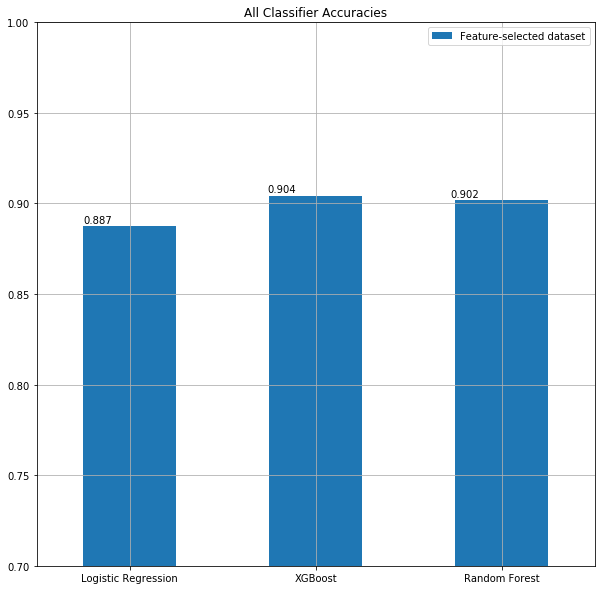

In [ ]:
#print("Accuracy\n" + acc_all.mean().to_string())

ax = acc_all.plot.bar(figsize=(10, 10))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x()*0.985, p.get_height()*1.002))
plt.ylim((0.7, 1.0))
plt.xticks(rotation=0)
plt.title("All Classifier Accuracies")
plt.grid()
plt.show()

From the result above, the mean accuracy of feature-selected data is slightly higher (0.3% higher) than the mean accuracy of the original data. The model that has the best accuracy is Support Vector Machine trained on feature-selected data with 79.6% accuracy. Multi-layer Perceptron accuracy improved by 2.3% with training on feature-selected data. But, there are some classifiers (Naive Bayes, k-Nearest Neighbors, Stochastic Gradient Descent, and AdaBoost) that don't get the advantage from training on feature-selected data.

To ensure this result, evaluate the model by using cross-validation.

<a id='Model-Evaluation'></a>
# D. Model Evaluation

To validate the accuracy result and evaluate the performance of these two models furthermore, do k-fold cross-validation with $k = 10$ on the whole dataset.
Metrics to validate are: accuracy, and ROC AUC score.

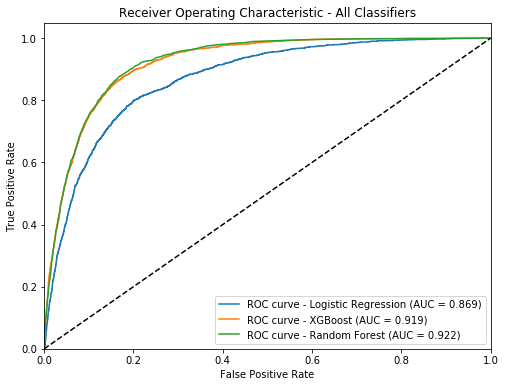

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc

# scoring = ["accuracy", "roc_auc"]

# scores = []
# # Feature-selected dataset
# print("Cross-validation on feature-selected data: started!")
# for clf_name, clf in clfs_rfe.items():
#     score = pd.DataFrame(cross_validate(clf, X_rfe, y, cv=StratifiedKFold(10, random_state=random_state, shuffle=True), scoring=scoring)).mean()
#     scores.append(score)
#     print(clf_name, "cross-validation: done!")
# cv_scores_rfe = pd.concat(scores, axis=1).rename(columns=dict(zip(range(len(clf_keys)), clf_keys)))
# print("Cross-validation on feature-selected data: done!")

# Plot the AUC-ROC curve for all classifiers on one graph
plt.figure(figsize=(8, 6))
for clf_name in clf_keys:
    y_scores = cross_val_predict(clfs_rfe[clf_name], X_rfe, y, cv=StratifiedKFold(10, random_state=random_state, shuffle=True), method="predict_proba")[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='ROC curve - %s (AUC = %.3f)' % (clf_name, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - All Classifiers')
plt.legend(loc="lower right")
plt.savefig('AUC_2')
plt.show()


Cross-validation on feature-selected data: started!
Logistic Regression cross-validation: done!
XGBoost cross-validation: done!
Random Forest cross-validation: done!
Cross-validation on feature-selected data: done!
Cross-validation ROC AUC score for feature-selected data:
0.9036324625168897
Cross-validation F1 score for feature-selected data:
0.41980320674485333


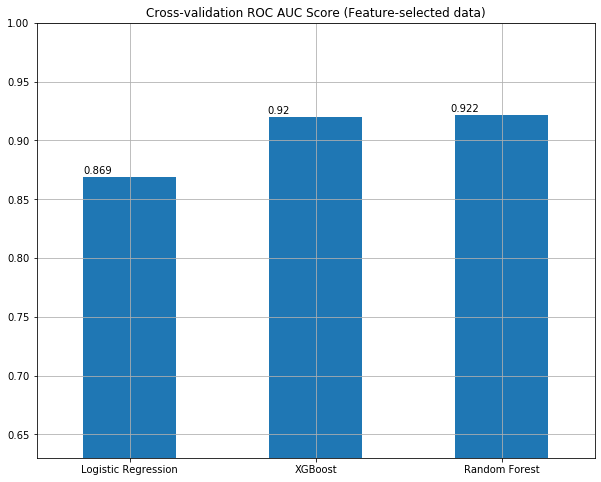

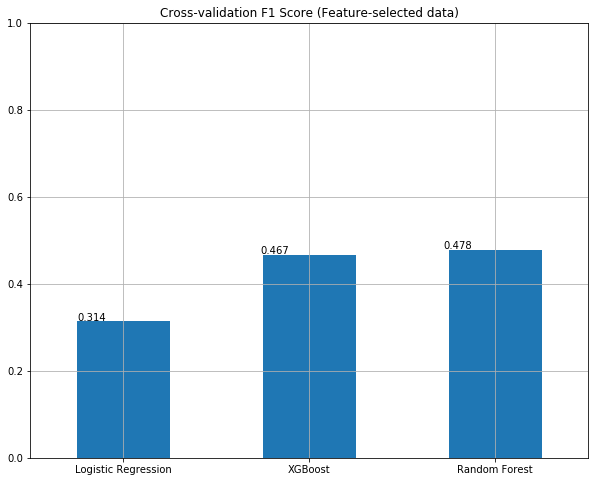

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, auc, f1_score

scoring = ["accuracy", "roc_auc", "f1"]

scores = []
# Feature-selected dataset
print("Cross-validation on feature-selected data: started!")
for clf_name, clf in clfs_rfe.items():
    score = pd.DataFrame(cross_validate(clf, X_rfe, y, cv=StratifiedKFold(10, random_state=random_state, shuffle=True), scoring=scoring)).mean()
    scores.append(score)
    print(clf_name, "cross-validation: done!")
cv_scores_rfe = pd.concat(scores, axis=1).rename(columns=dict(zip(range(len(clf_keys)), clf_keys)))
print("Cross-validation on feature-selected data: done!")

cv_roc_auc_selected = cv_scores_rfe.loc["test_roc_auc"].rename("Feature-selected data")
mean_roc_auc_selected = cv_roc_auc_selected.mean()

cv_f1_selected = cv_scores_rfe.loc["test_f1"].rename("Feature-selected data")
mean_f1_selected = cv_f1_selected.mean()

print("Cross-validation ROC AUC score for feature-selected data:\n" + str(mean_roc_auc_selected))
print("Cross-validation F1 score for feature-selected data:\n" + str(mean_f1_selected))

ax = cv_roc_auc_selected.plot.bar(figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x() * 0.985, p.get_height() * 1.003))
plt.xticks(rotation=0)
plt.ylim((0.63, 1.0))
plt.title("Cross-validation ROC AUC Score (Feature-selected data)")
plt.grid()
plt.show()

ax = cv_f1_selected.plot.bar(figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x() * 0.985, p.get_height() * 1.003))
plt.xticks(rotation=0)
plt.ylim((0.0, 1.0))
plt.title("Cross-validation F1 Score (Feature-selected data)")
plt.grid()
plt.show()


Let's visualize cross-validation accuracy, ROC AUC score, and fit time results.

Cross-validation accuracy for feature-selected data:
0.899601412788067


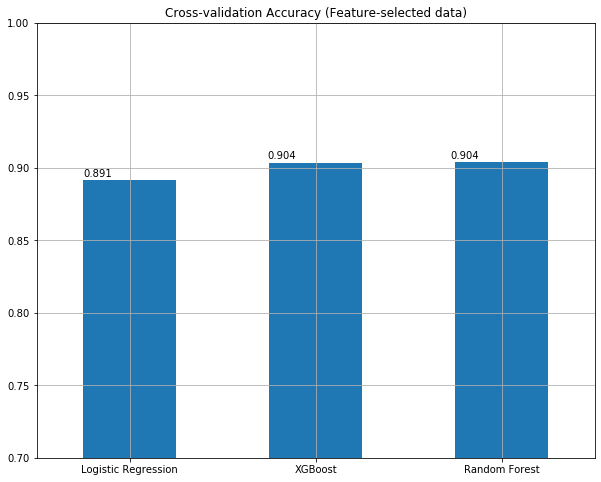

In [ ]:
cv_acc_selected = cv_scores_rfe.loc["test_accuracy"].rename("Feature-selected data")
mean_acc_selected = cv_acc_selected.mean()

print("Cross-validation accuracy for feature-selected data:\n" + str(mean_acc_selected))
ax = cv_acc_selected.plot.bar(figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x()*0.985, p.get_height()*1.003))
plt.xticks(rotation=0)
plt.ylim((0.7, 1.0))
plt.title("Cross-validation Accuracy (Feature-selected data)")
plt.grid()
plt.show()


Cross-validation ROC AUC score for feature-selected data:
0.9036324625168897


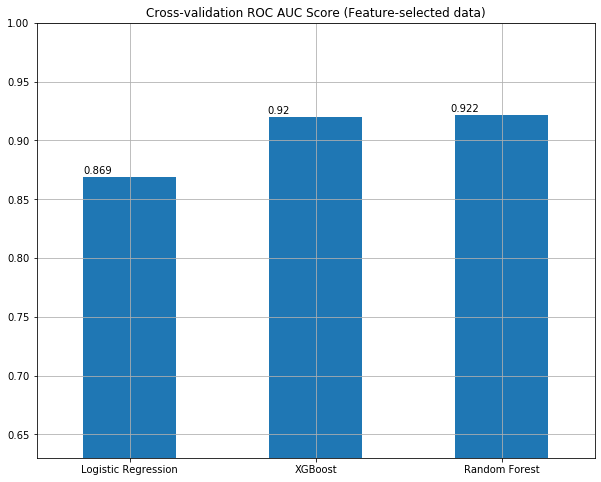

In [ ]:
cv_roc_auc_selected = cv_scores_rfe.loc["test_roc_auc"].rename("Feature-selected data")
mean_roc_auc_selected = cv_roc_auc_selected.mean()

print("Cross-validation ROC AUC score for feature-selected data:\n" + str(mean_roc_auc_selected))
ax = cv_roc_auc_selected.plot.bar(figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x()*0.985, p.get_height()*1.003))
plt.xticks(rotation=0)
plt.ylim((0.63, 1.0))
plt.title("Cross-validation ROC AUC Score (Feature-selected data)")
plt.grid()
plt.show()
